### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import make_union, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from textblob import TextBlob

## Data Aquisition

In [2]:
# Load in and examine data
reddit = pd.read_csv('reddit_posts.csv')
print(reddit.shape)
print(reddit.columns)
reddit.head()

(26688, 53)
Index(['adserver_click_url', 'adserver_imp_pixel', 'archived', 'author',
       'author_flair_css_class', 'author_flair_text', 'contest_mode',
       'created_utc', 'disable_comments', 'distinguished', 'domain', 'downs',
       'edited', 'gilded', 'hide_score', 'href_url', 'id', 'imp_pixel',
       'is_self', 'link_flair_css_class', 'link_flair_text', 'locked', 'media',
       'media_embed', 'mobile_ad_url', 'name', 'num_comments', 'original_link',
       'over_18', 'permalink', 'post_hint', 'preview', 'promoted',
       'promoted_by', 'promoted_display_name', 'promoted_url', 'quarantine',
       'retrieved_on', 'saved', 'score', 'secure_media', 'secure_media_embed',
       'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'third_party_tracking', 'third_party_tracking_2', 'thumbnail', 'title',
       'ups', 'url'],
      dtype='object')


,adserver_click_url,adserver_imp_pixel,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,disable_comments,distinguished,...,spoiler,stickied,subreddit,subreddit_id,third_party_tracking,third_party_tracking_2,thumbnail,title,ups,url
0,NaN,NaN,False,johnnyawesome0,NaN,NaN,False,1480697304,NaN,NaN,...,False,False,techsupport,t5_2qioo,NaN,NaN,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,NaN,NaN,False,Silverfin113,NaN,NaN,False,1480697424,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,NaN,NaN,False,bookbooksbooks,NaN,NaN,False,1480697613,NaN,NaN,...,False,False,gamedev,t5_2qi0a,NaN,NaN,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,NaN,NaN,False,[deleted],NaN,NaN,False,1480697634,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,NaN,NaN,False,caffeine_potent,NaN,NaN,False,1480697748,NaN,NaN,...,False,False,learnpython,t5_2r8ot,NaN,NaN,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


In [3]:
# Check the types and counts of each column
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 53 columns):
adserver_click_url        0 non-null float64
adserver_imp_pixel        0 non-null float64
archived                  26688 non-null bool
author                    26688 non-null object
author_flair_css_class    435 non-null object
author_flair_text         351 non-null object
contest_mode              26688 non-null bool
created_utc               26688 non-null int64
disable_comments          0 non-null float64
distinguished             85 non-null object
domain                    26688 non-null object
downs                     26688 non-null float64
edited                    26688 non-null object
gilded                    26688 non-null float64
hide_score                26688 non-null bool
href_url                  0 non-null float64
id                        26688 non-null object
imp_pixel                 0 non-null float64
is_self                   26688 non-null bool
link_fla

## Data Cleaning & EDA

In [4]:
# simply get rid of columns that have too many nulls to be useful, <1000 actual values in a dataset of 26688 observations
drop_list = ['adserver_click_url','adserver_imp_pixel','author_flair_css_class','author_flair_text',
             'disable_comments', 'distinguished', 'href_url', 'imp_pixel','media', 'mobile_ad_url', 'original_link',
             'promoted', 'promoted_by', 'promoted_display_name', 'promoted_url', 
            'secure_media', 'third_party_tracking', 'third_party_tracking_2']

reddit.drop(drop_list, axis = 1, inplace = True)
print(reddit.columns)
reddit.head()

Index(['archived', 'author', 'contest_mode', 'created_utc', 'domain', 'downs',
       'edited', 'gilded', 'hide_score', 'id', 'is_self',
       'link_flair_css_class', 'link_flair_text', 'locked', 'media_embed',
       'name', 'num_comments', 'over_18', 'permalink', 'post_hint', 'preview',
       'quarantine', 'retrieved_on', 'saved', 'score', 'secure_media_embed',
       'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'thumbnail', 'title', 'ups', 'url'],
      dtype='object')


,archived,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,...,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,ups,url
0,False,johnnyawesome0,False,1480697304,self.techsupport,0.0,False,0.0,False,5g49s2,...,{},I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,False,Silverfin113,False,1480697424,self.learnprogramming,0.0,False,0.0,False,5g4a5p,...,{},I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,False,bookbooksbooks,False,1480697613,self.gamedev,0.0,False,0.0,False,5g4att,...,{},"I'm writing an article called ""Video Games Tha...",False,False,gamedev,t5_2qi0a,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,False,[deleted],False,1480697634,self.learnprogramming,0.0,1480698462,0.0,False,5g4awr,...,{},[deleted],False,False,learnprogramming,t5_2r7yd,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,False,caffeine_potent,False,1480697748,self.learnpython,0.0,1480709138,0.0,False,5g4bcr,...,{},I have the following representation of argumen...,False,False,learnpython,t5_2r8ot,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


I'm not sure yet exactly what it is I want to predict, so I'll try to figure that out now.

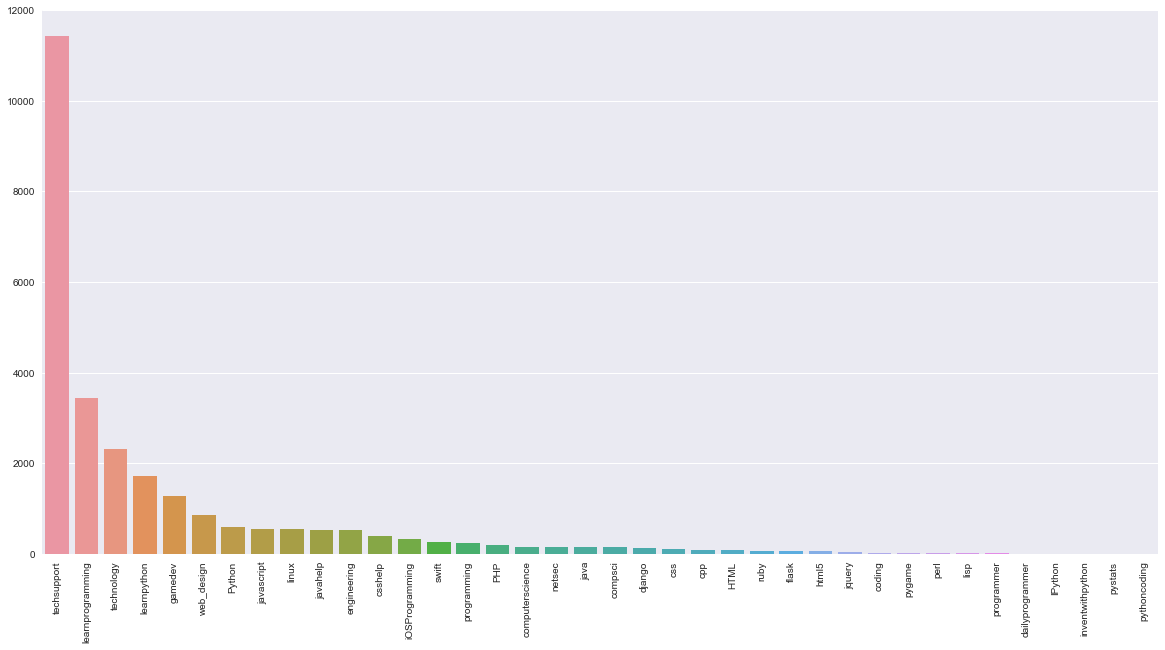

In [5]:
# Create a list of subreddits and a corresponding list of their number of occurences
val_counts = reddit['subreddit'].value_counts()
names = []
counts = []
for name, count in val_counts.items():
    names.append(name)
    counts.append(count)

# Create a barplot using the lists above
plt.figure(figsize = (20,10))
sub_bar = sns.barplot(names, counts)
for item in sub_bar.get_xticklabels():
    item.set_rotation(90)
None

I think I'm going to try predicting subreddits. If it works as is I'll keep them the way they are, but if necessary I can binarize the column as techsupport/ not techsupport

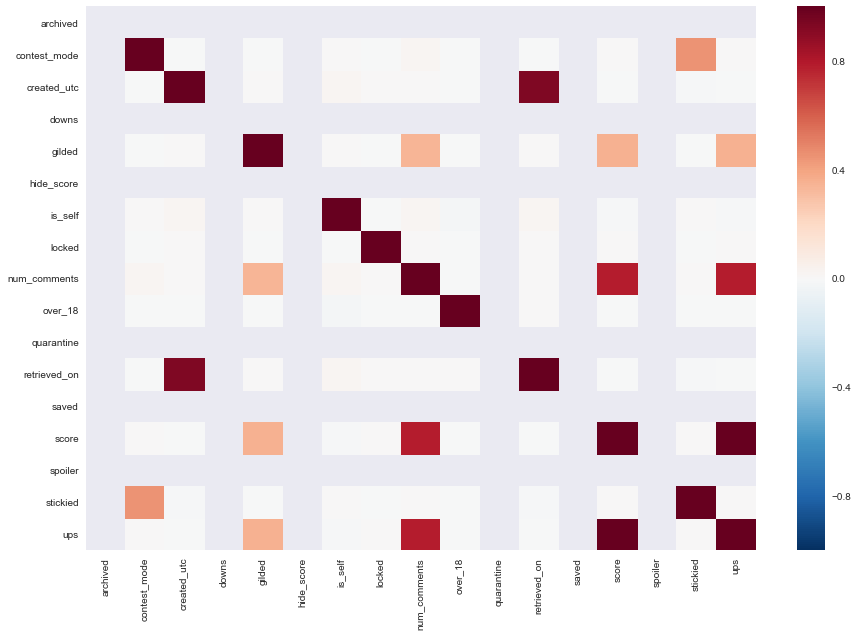

In [6]:
# Create a correlation heatmap for all of the numerical values
corr = reddit.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr)
None

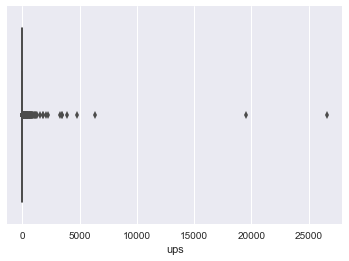

In [7]:
sns.boxplot('ups', data = reddit)
None

## Feature Engineering and Modification

In [8]:
# Create 'fulltext': a single column that contains the title and text of a post as a single string
reddit['fulltext'] = reddit['title'] + '\n' + reddit['selftext']

In [9]:
# Create 'techsupport': a binarized copy of 'subreddit', as a model target
reddit['techsupport'] = reddit['subreddit'].apply(lambda x: 1 if x == 'techsupport' else 0)
reddit.head(3)

,archived,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,...,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,ups,url,fulltext,techsupport
0,False,johnnyawesome0,False,1480697304,self.techsupport,0.0,False,0.0,False,5g49s2,...,False,False,techsupport,t5_2qioo,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...,Help with audio set-up\nI have a Sony surround...,1
1,False,Silverfin113,False,1480697424,self.learnprogramming,0.0,False,0.0,False,5g4a5p,...,False,False,learnprogramming,t5_2r7yd,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...,Optimizing code for speed\nI've written what s...,0
2,False,bookbooksbooks,False,1480697613,self.gamedev,0.0,False,0.0,False,5g4att,...,False,False,gamedev,t5_2qi0a,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...,Seeking Tales of Development Woe (and Triumph)...,0


In [10]:
# This is a list of columns that have a couple thousand values. I know as a reddit user that these four are 
# optional additions that draw interested readers in as they scroll through a page of post titles. I suspect that 
# these will increase the magnitude of votes ('ups' and 'downs'), since more people will read these posts.
edit_list = ['link_flair_css_class', 'link_flair_text', 'post_hint', 'preview']

# Because these are rare enough, I'll simply binarize them to see whether they are present (1) or not (0) 
for col in edit_list:
    reddit[col] = reddit[col].apply(lambda x: 1 if type(x) == str else 0)
    
reddit[edit_list].head(10)

,link_flair_css_class,link_flair_text,post_hint,preview
0,0,0,0,0
1,0,0,0,0
2,1,1,0,0
3,1,1,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0
9,0,0,1,1


In [11]:
# Because the same posts will likely have many of these categories, I will create a new 'flair' column with a 1 
# if any of the other four have a 1, else 0. 
reddit['flair'] = reddit['link_flair_css_class'] + reddit['link_flair_text'] + reddit['post_hint'] + reddit['preview']
reddit['flair'] = reddit['flair'].apply(lambda x: 1 if x > 0 else 0)
reddit['flair'].value_counts()

0    19108
1     7580
Name: flair, dtype: int64

### Techsupport prediction model

I originally created a model that attempted to predict the specific subreddit that a post belonged to, but this was rather unsuccessful, given that many subreddits have very few posts, and the dataset is dominated by r/techsupport, so I simply created a 'techsupport' binary feature as a target 

In [12]:
# Set the data we will be predicting from and the target 
y = reddit['techsupport']
X = reddit['fulltext']

# Split the data into a training and testing set, 
# so that the model can be evaluated based on its performance on data that it hasn't been trained on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [13]:
# Use CountVectorizer to transform each 'fulltext' string into a count of occurences of each words, 
# not including the most common english words (stop_words)
cv = CountVectorizer(stop_words = 'english')
cv.fit(X_train)
X_cv = pd.DataFrame(cv.transform(X_train).todense(), 
             columns=cv.get_feature_names())

In [14]:
# Use Truncated Singular Value Decomposition to reduce the dimensionality of the CountVectorized data
tsvd = TruncatedSVD(n_components=1700)
tsvd.fit(X_cv)
X_tsvd = tsvd.transform(X_cv)

In [15]:
# Create and fit a logistic regression model
lr = LogisticRegression()
lr.fit(X_tsvd, y_train)

# Score the model on the train data
lr.score(X_tsvd, y_train)

0.9703579418344519

Now that we have a working model, which seems to work well, although I suspect it is overfit, we can create a pipeline to streamline the data preparation for the test set and any other data going forward

In [16]:
# Create a pipeline with the objects used to prep the data above
pipe = make_pipeline(
    CountVectorizer(),
    TruncatedSVD(n_components=1700),
    LogisticRegression()
)

In [17]:
# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [18]:
# Score the model from the pipeline on the training data
pipe.score(X_train, y_train)

0.97444071588366887

In [19]:
# Score the model from the pipeline on the test data, which it hasn't seen before
pipe.score(X_test, y_test)

0.94402815622161673

In [20]:
# Generate a confusion matrix DataFrame
con_mat = confusion_matrix(y_test, pipe.predict(X_test))
con_mat_df = pd.DataFrame(con_mat, 
                          columns = ['predicted non-techsupport', 'predicted techsupport'],
                          index = ['actually non-techsupport', 'actually techsupport'])

con_mat_df

,predicted non-techsupport,predicted techsupport
actually non-techsupport,4881,153
actually techsupport,340,3434


In [21]:
# Generate a classification report
class_rep = classification_report(y_test, pipe.predict(X_test))
print(class_rep)

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      5034
          1       0.96      0.91      0.93      3774

avg / total       0.94      0.94      0.94      8808



This model ended up performing quite well!

### Upvote Prediction Model

Here I'm going to try to make a model with sentiment features extracted from the text in an attempt to predict whether a post has > 5 upvotes. These posts make up about 1/10th of the dataset

In [22]:
# Create a binary column with >5 ups = 1, 10 or fewer ups = 0
reddit['popular'] = reddit['ups'].apply(lambda x: 1 if x > 5 else 0)
reddit['popular'].value_counts()

0    24114
1     2574
Name: popular, dtype: int64

In [23]:
# The baseline I am trying to beat with the model is the percentage I would get correct if I simply guessed that 
# every post is not 'popular'
24114/26688

0.9035521582733813

In [24]:
# Use Textblob sentiment analysis to create two new features, subjectivity and polarity
reddit['subjectivity'] = reddit['fulltext'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
reddit['polarity'] = reddit['fulltext'].apply(lambda x: TextBlob(x).sentiment.polarity)
reddit.head()

,archived,author,contest_mode,created_utc,domain,downs,edited,gilded,hide_score,id,...,thumbnail,title,ups,url,fulltext,techsupport,flair,popular,subjectivity,polarity
0,False,johnnyawesome0,False,1480697304,self.techsupport,0.0,False,0.0,False,5g49s2,...,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...,Help with audio set-up\nI have a Sony surround...,1,0,0,0.558333,0.291667
1,False,Silverfin113,False,1480697424,self.learnprogramming,0.0,False,0.0,False,5g4a5p,...,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...,Optimizing code for speed\nI've written what s...,0,0,1,0.370912,0.015735
2,False,bookbooksbooks,False,1480697613,self.gamedev,0.0,False,0.0,False,5g4att,...,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...,Seeking Tales of Development Woe (and Triumph)...,0,1,1,0.393056,-0.030035
3,False,[deleted],False,1480697634,self.learnprogramming,0.0,1480698462,0.0,False,5g4awr,...,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...,[Java] Finding smallest value in an array\n[de...,0,1,0,0.000000,0.000000
4,False,caffeine_potent,False,1480697748,self.learnpython,0.0,1480709138,0.0,False,5g4bcr,...,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...,currying functions using functools\nI have the...,0,0,1,0.355556,-0.038889


In [25]:
# Initialize the data to be included in the model and the target variable, and split the train/test sets
Xs = reddit[['subjectivity', 'polarity','num_comments','flair']]
ys = reddit['popular']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size = 0.33, stratify = ys)

In [26]:
# Initialize, and then fit a score a Random Forest Classifier on the training set
rfc = RandomForestClassifier()
rfc.fit(Xs_train, ys_train)
rfc.score(Xs_train, ys_train)

0.98137583892617453

In [27]:
# Evaluate the model on test data it hasn't seen before
rfc.score(Xs_test, ys_test)

0.91189827429609449

In [28]:
# Generate a confusion matrix DataFrame
con_mat = confusion_matrix(ys_test, rfc.predict(Xs_test))
con_mat_df = pd.DataFrame(con_mat, 
                          columns = ['predicted unpopular', 'predicted popular'],
                          index = ['actually unpopular', 'actually popular'])

con_mat_df

,predicted unpopular,predicted popular
actually unpopular,7765,193
actually popular,583,267


In [29]:
# Generate a classification report
class_rep = classification_report(ys_test, rfc.predict(Xs_test))
print(class_rep)

             precision    recall  f1-score   support

          0       0.93      0.98      0.95      7958
          1       0.58      0.31      0.41       850

avg / total       0.90      0.91      0.90      8808



This model ends up working marginally better than the already high baseline

## Latent Dirichlet Allocation

Next, I will attempt a Latent Dirichlet Allocation to split up the posts by topic. I hope that these will line up with the subreddits. If I have cluster/topics that line up perfectly with subreddits, several clusters/topics within a larger subreddit, or several of the smaller subreddits within a single topic, I will consider this successful. 

In [30]:
# Start with a CountVectorizer
cv = CountVectorizer(stop_words='english')
cv.fit(reddit['fulltext'])
cv_X = cv.transform(reddit['fulltext'])
cv_X

<26688x64915 sparse matrix of type '<class 'numpy.int64'>'
	with 992507 stored elements in Compressed Sparse Row format>

In [31]:
# n = number of target clusters: The rest of the notebook below operates in terms of this 'n' value
n = 20

# Initialize and fit a Latent Dirichlet Allocation to categorize every word/feature into one of 10 categories
lda = LatentDirichletAllocation(n_topics=n)

lda.fit(cv_X)

/Users/Quentin/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=20, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [32]:
# Create a DataFrame with the posts vs their lda scores (lda_df), and a DataFrame with features and their 
# individual scores (feature_scores)
lda_df = pd.DataFrame(lda.transform(cv_X))

feature_scores = pd.DataFrame(lda.components_,
                      columns=cv.get_feature_names())

In [33]:
# For each topic, print a string containing the top 25 features (words from CountVectorizer)
for topic in range(n):
    print('Topic', topic)
    word_list = feature_scores.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

Topic 0
vm sony 25 osx shell spotify radius pitch powers st ray connectors gnome truly se subprocess dd slider fedora debian macro garbage easyprocess hit_points blu 

Topic 1
marknativeasoptional 198 execution 224 866 8319 merge groups isr µs unsigned interrupt _________________________________________________________________________________________________________ svchost protobuf docker circular current_row current_col generates alista mixed bat assigning matriz 

Topic 2
internet router network wifi server connection connect linux wireless connected ethernet ip speed access adapter modem address devices home house ping download using iphone 192 

Topic 3
number controller numbers int enter println count input total public user function args new letter scanner math counter sec program average java prints print calculate 

Topic 4
com https http imgur html github css reddit link page post comments code posts sub text width url js list io blog content body font 

Topic 5
learn program

In [34]:
# In this DataFrame, I can see the score that each post recieved in each topic, with the max being the topic that
# the post as a whole belongs to.
lda_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.340719,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.319488,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.094183,0.207515,0.002381,0.002381
1,0.000147,0.338382,0.000147,0.022996,0.007008,0.000147,0.003409,0.456509,0.142202,0.027583,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147
2,0.000450,0.027477,0.000450,0.000450,0.177401,0.000450,0.013977,0.000450,0.000450,0.064663,0.000450,0.000450,0.000450,0.000450,0.000450,0.645829,0.064347,0.000450,0.000450,0.000450
3,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.199294,0.007143,0.007143,0.150000,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.529278,0.007143
4,0.000625,0.000625,0.071058,0.487923,0.000625,0.000625,0.014092,0.202658,0.083727,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.131793,0.000625,0.000625,0.000625,0.000625


In [35]:
# Turn the df into a list of lists to make the next step easier to manipulate
lda_list = lda_df.values.tolist()

# For each row, append the index of the maximum to the row, this corresponds to the topic
for row in lda_list:
    row.append(row.index(max(row)))
    
# Turn the list of lists back into a DataFrame, with a new topic column
columns = list(range(n))
columns.append('topic')
new_lda_df = pd.DataFrame(lda_list, columns = columns)
new_lda_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,topic
0,0.340719,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.319488,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.094183,0.207515,0.002381,0.002381,0
1,0.000147,0.338382,0.000147,0.022996,0.007008,0.000147,0.003409,0.456509,0.142202,0.027583,...,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,0.000147,7
2,0.000450,0.027477,0.000450,0.000450,0.177401,0.000450,0.013977,0.000450,0.000450,0.064663,...,0.000450,0.000450,0.000450,0.000450,0.645829,0.064347,0.000450,0.000450,0.000450,15
3,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.199294,0.007143,0.007143,...,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.007143,0.529278,0.007143,18
4,0.000625,0.000625,0.071058,0.487923,0.000625,0.000625,0.014092,0.202658,0.083727,0.000625,...,0.000625,0.000625,0.000625,0.000625,0.131793,0.000625,0.000625,0.000625,0.000625,3


In [36]:
# Check the number of posts in each topic
new_lda_df['topic'].value_counts()

9     5265
17    5052
8     3657
15    2536
7     1503
5     1179
14    1133
6     1121
16    1071
10    1040
2      985
4      548
18     267
13     263
1      218
3      199
0      194
12     165
19     156
11     136
Name: topic, dtype: int64

In [37]:
# Now that every post has a topic I can compare Topics with subreddits
lda_comp = pd.concat([reddit['subreddit'], new_lda_df['topic']], axis = 1)
lda_comp.head()

,subreddit,topic
0,techsupport,0
1,learnprogramming,7
2,gamedev,15
3,learnprogramming,18
4,learnpython,3


In [38]:
# Generate a list of subreddits
sub_list = []
for sub in lda_comp['subreddit'].value_counts().items():
    sub_list.append(sub[0])

print(sub_list)

['techsupport', 'learnprogramming', 'technology', 'learnpython', 'gamedev', 'web_design', 'Python', 'javascript', 'linux', 'javahelp', 'engineering', 'csshelp', 'iOSProgramming', 'swift', 'programming', 'PHP', 'computerscience', 'netsec', 'java', 'compsci', 'django', 'css', 'cpp', 'HTML', 'ruby', 'flask', 'html5', 'jquery', 'coding', 'pygame', 'perl', 'lisp', 'programmer', 'dailyprogrammer', 'IPython', 'inventwithpython', 'pystats', 'pythoncoding']


In [39]:
# Generate a list for each topic that gets a count for that topic in each subreddit:
topic_array = []
for topic in range(n):
    row = []
    for sub in sub_list:
        sub_temp = lda_comp.loc[lda_comp['subreddit'] == sub]
        count = sub_temp.loc[sub_temp['topic'] == topic].count()
        val = count[1]
        row.append(val)
    topic_array.append(row)

# Transform this array into a df with the sub_list as indices
topic_dict = {}
for topic in range(n):
    topic_dict['topic {}'.format(topic)] = topic_array[topic]
    
topic_df = pd.DataFrame(topic_dict, index = sub_list)

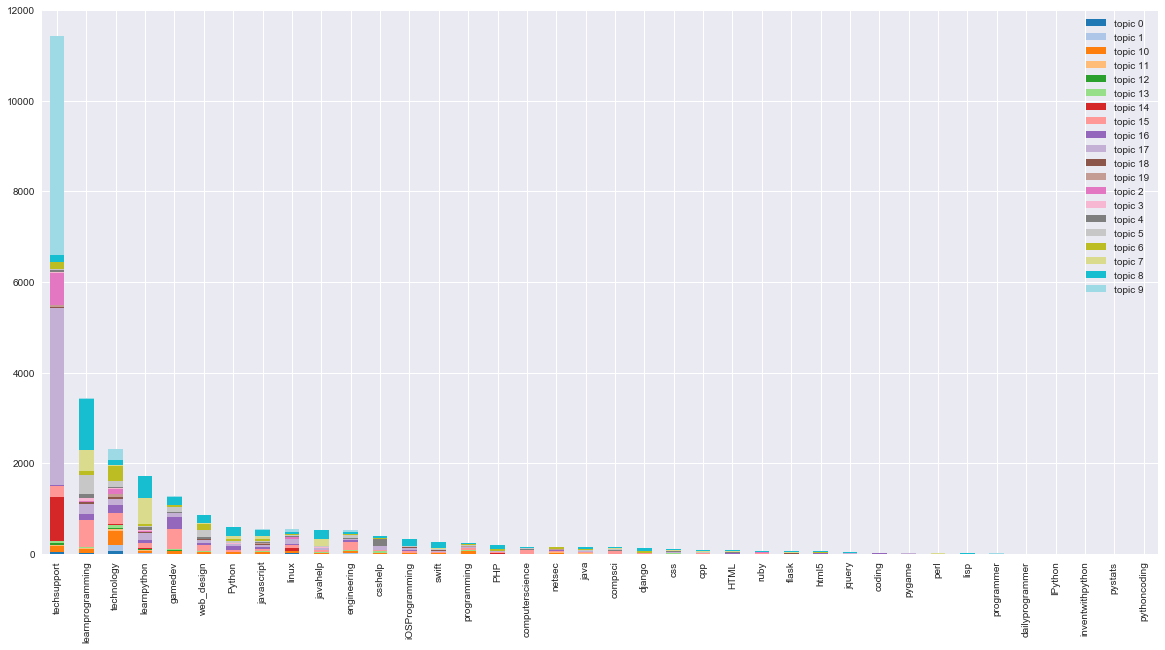

In [40]:
# Show the occurences of each topic in each subbreddit
topic_df.plot(kind='bar', stacked=True, figsize = (20,10), colormap = 'tab20')
None

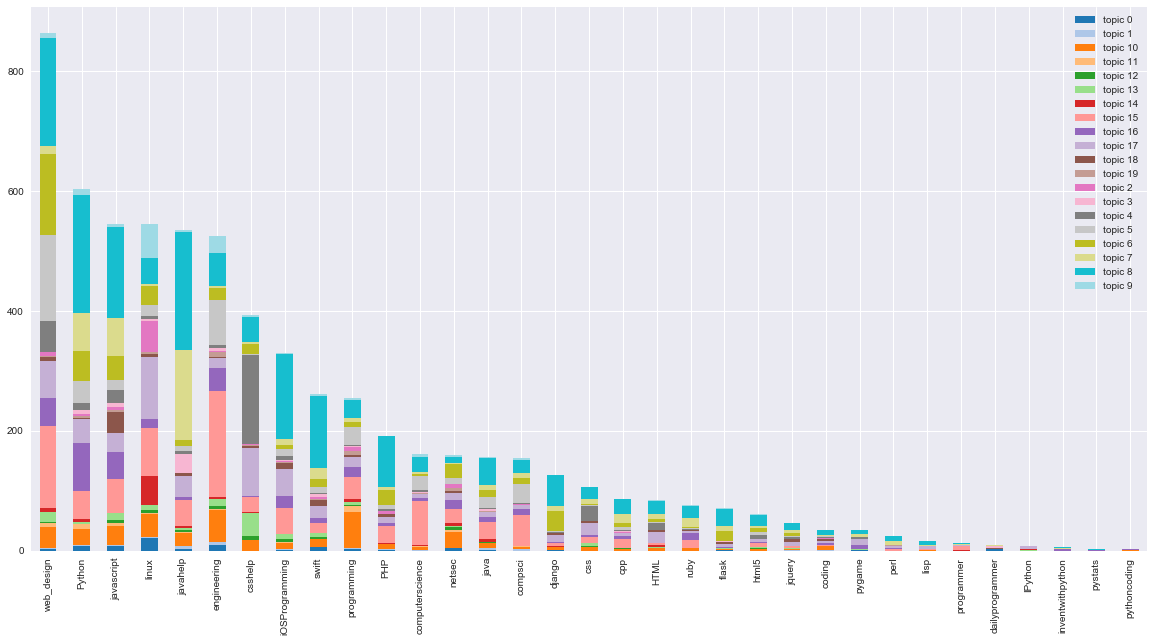

In [41]:
# Show the occurences of each topic in each subbreddit not including the five first subreddits, in order to 
# better visualize the distributions in the smaller ones
topic_df[5:].plot(kind='bar', stacked=True, figsize = (20,10), colormap = 'tab20')
None

Looking at the barplots above, it is clear that these most of these clusters did a pretty poor job of identifying which subreddit a post belongs to. That being said, as an unsupervised learning model, the LDA shouldn't be expected to necessarily line up with existing patterns. The clusters identified by the LDA model are based on the subject of a post, but since these subreddits all deal with programming, it should be expected that there will be a great deal of overlap in subject matter.
When experimenting with the number of clusters, there are several cases where a topic or two may fall almost entirely within a subreddit. Unfortunately, even in these cases, there are a couple posts of that topic elsewhere. 